# 머신러닝으로 2021시즌 MLB 타자들의 홈런갯수 예측해보기

1. EDA & Feature Engineering
2. Modeling & Prediction

---
### 칼럼
- 'last_name'
- 'first_name'
- 'player_id'
- 'year'
- 'b_ab'
- 'b_total_pa'
- 'b_home_run'
- 'batting_avg'
- 'slg_percent'
- 'on_base_percent',
- 'on_base_plus_slg'
- 'xba'
- 'xslg'
- 'woba'
- 'xwoba'
- 'xobp'
- 'xiso'
- 'wobacon'
- 'xwobacon'
- 'bacon'
- 'xbacon'
- 'xbadiff'
- 'xslgdiff',
- 'wobadif'
- 'exit_velocity_avg'
- 'launch_angle_avg',
- 'sweet_spot_percent'
- 'barrels'
- 'barrel_batted_rate',
- 'poorlyweak_percent'
- 'hard_hit_percent'
- 'z_swing_percent',
- 'z_swing_miss_percent'
- 'oz_swing_miss_percent'
- 'oz_contact_percent',
- 'groundballs_percent'
- 'flyballs_percent'
- 'linedrives_percent',
---

## EDA & Feature Engineering
- Train Dataset : 2015년 ~ 2020년 타자들의 성적 및 홈런갯수
- Test Dataset : 2021년(7월 21일기준) 타자들의 성적 및 홈런갯수 (출전게임 수 포함 / Prediction 시 홈런 칼럼 삭제)

In [7]:
import pandas as pd

df_old = pd.read_csv('2015_2020.csv')
df_now = pd.read_csv('2021.csv')

### 필요없는 칼럼 삭제
- 선수이름, Unnamed:(?) 칼럼 삭제
- 2020년 데이터 삭제 (단축시즌이었기 때문에)
- 연도표시 칼럼 삭제
- 2021년 데이터의 player_id, 이름은 따로 저장 (예측때 사용)

In [8]:
# 선수이름, Unamed 칼럼 삭제
df_old = df_old.drop(['last_name', ' first_name', 'Unnamed: 38'], axis=1)
player_id = df_now['player_id']
name = df_now['last_name'] + df_now[' first_name']
df_now = df_now.drop(['last_name', ' first_name', 'Unnamed: 39'], axis=1)

# 2020년 데이터 삭제
df_old = df_old[df_old.year != 2020]

# 연도 칼럼 삭제
df_old = df_old.drop(['year'], axis=1)
df_now = df_now.drop(['year'], axis=1)

print(df_old.shape)
print(df_now.columns)

(708, 35)
Index(['player_id', 'b_ab', 'b_total_pa', 'b_home_run', 'batting_avg',
       'slg_percent', 'on_base_percent', 'on_base_plus_slg', 'b_game', 'xba',
       'xslg', 'woba', 'xwoba', 'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon',
       'xbacon', 'xbadiff', 'xslgdiff', 'wobadif', 'exit_velocity_avg',
       'launch_angle_avg', 'sweet_spot_percent', 'barrels',
       'barrel_batted_rate', 'poorlyweak_percent', 'hard_hit_percent',
       'z_swing_percent', 'z_swing_miss_percent', 'oz_swing_miss_percent',
       'oz_contact_percent', 'groundballs_percent', 'flyballs_percent',
       'linedrives_percent'],
      dtype='object')


### 칼럼 하나씩 살펴보고 이상치 제거 / 제외할 칼럼 선정 (Outlier remove)

- 분석 대상 :
    -  'xba', 'xslg', 'xwoba', 'xobp', 'xiso',
       'xwobacon', 'xbacon', 'xbadiff', 'xslgdiff',
       'wobadif', 'exit_velocity_avg', 'launch_angle_avg',
       'sweet_spot_percent', 'barrels', 'barrel_batted_rate',
       'poorlyweak_percent', 'hard_hit_percent'
       'z_swing_miss_percent', 'oz_contact_percent',
       'flyballs_percent', 'linedrives_percent'

In [9]:
df_old.head()

,player_id,b_ab,b_total_pa,b_home_run,batting_avg,slg_percent,on_base_percent,on_base_plus_slg,xba,xslg,...,barrel_batted_rate,poorlyweak_percent,hard_hit_percent,z_swing_percent,z_swing_miss_percent,oz_swing_miss_percent,oz_contact_percent,groundballs_percent,flyballs_percent,linedrives_percent
142,116338,521,567,22,0.240,0.409,0.293,0.702,0.230,0.370,...,5.0,2.9,35.3,72.7,17.2,36.3,63.7,49.4,22.6,20.9
143,120074,528,614,37,0.273,0.553,0.360,0.913,0.299,0.611,...,13.1,1.6,49.5,71.0,17.0,34.6,65.4,37.6,25.6,28.7
144,121347,523,620,33,0.250,0.486,0.356,0.842,0.245,0.491,...,10.9,1.0,44.2,67.6,26.1,46.9,53.1,43.6,24.9,24.9
145,133380,475,516,17,0.246,0.423,0.297,0.720,0.237,0.400,...,5.6,3.4,35.0,73.6,12.3,29.1,70.9,37.6,24.5,29.1
146,134181,567,619,18,0.287,0.453,0.334,0.788,0.293,0.477,...,5.5,2.2,40.8,62.2,10.9,25.2,74.8,42.4,18.4,31.6


In [17]:
old_corr = df_old.columns

#### test_data에도 똑같이 맞춰 삭제하기

In [18]:
df_now = df_now[old_corr]
df_now.columns

Index(['player_id', 'b_ab', 'b_total_pa', 'batting_avg', 'slg_percent',
       'on_base_percent', 'on_base_plus_slg', 'xba', 'xslg', 'woba', 'xwoba',
       'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon', 'xbadiff',
       'xslgdiff', 'wobadif', 'exit_velocity_avg', 'launch_angle_avg',
       'sweet_spot_percent', 'barrels', 'barrel_batted_rate',
       'poorlyweak_percent', 'hard_hit_percent', 'z_swing_percent',
       'z_swing_miss_percent', 'oz_swing_miss_percent', 'oz_contact_percent',
       'groundballs_percent', 'flyballs_percent', 'linedrives_percent'],
      dtype='object')

In [51]:
# test_data의 정답데이터 분리
answer = df_now['b_home_run']
df_now = df_now.drop(['b_home_run'], axis=1)

In [19]:
print(df_old.shape)
print(df_now.shape)

(708, 34)
(137, 34)


#### 현재 데이터에 부족한 게임 수 조정하기

In [11]:
df_now['progress'] = df_now['b_game'] / 168
df_now['progress']

0      0.428571
1      0.494048
2      0.529762
3      0.511905
4      0.511905
         ...   
132    0.541667
133    0.464286
134    0.547619
135    0.529762
136    0.470238
Name: progress, Length: 137, dtype: float64

In [12]:
df_now['progress'] = df_now['progress'] + 1
df_now['progress']

0      1.428571
1      1.494048
2      1.529762
3      1.511905
4      1.511905
         ...   
132    1.541667
133    1.464286
134    1.547619
135    1.529762
136    1.470238
Name: progress, Length: 137, dtype: float64

In [13]:
df_now['b_ab'] = round(df_now['b_ab'] * df_now['progress'], 0)
df_now['b_total_pa'] = round(df_now['b_total_pa'] * df_now['progress'], 0)
df_now['barrels'] = round(df_now['barrels'] * df_now['progress'], 0)
df_now.head()

,player_id,b_ab,b_total_pa,b_home_run,batting_avg,slg_percent,on_base_percent,on_base_plus_slg,b_game,xba,...,poorlyweak_percent,hard_hit_percent,z_swing_percent,z_swing_miss_percent,oz_swing_miss_percent,oz_contact_percent,groundballs_percent,flyballs_percent,linedrives_percent,progress
0,408234,383.0,417.0,7,0.243,0.347,0.298,0.645,72,0.219,...,3.1,48.5,68.2,20.9,41.8,58.2,50.0,24.2,21.6,1.428571
1,443558,430.0,502.0,19,0.299,0.545,0.372,0.917,83,0.282,...,3.4,54.0,73.9,21.1,46.2,53.8,45.5,26.0,21.3,1.494048
2,444482,476.0,528.0,4,0.254,0.399,0.328,0.726,89,0.242,...,3.9,41.1,65.7,13.7,41.0,58.4,53.5,14.7,24.8,1.529762
3,453568,440.0,508.0,5,0.261,0.364,0.357,0.721,86,0.284,...,6.0,40.9,67.0,13.1,31.2,68.1,51.2,22.2,21.8,1.511905
4,457705,435.0,534.0,16,0.229,0.441,0.351,0.792,86,0.247,...,4.1,38.2,62.4,19.4,47.8,51.5,45.2,28.1,20.7,1.511905


In [14]:
import numpy as np

# b_game(게임 수), progress(진행률) 칼럼 삭제
df_now = df_now.drop(['b_game', 'progress'], axis=1)

# old data에서 로그변환한 홈런 칼럼 따로 저장하고 삭제
y_data = np.log1p(df_old['b_home_run'])
df_old = df_old.drop(['b_home_run'], axis=1)

# shape 비교
print(df_old.columns, df_old.shape)
print(df_now.columns, df_now.shape)

Index(['player_id', 'b_ab', 'b_total_pa', 'batting_avg', 'slg_percent',
       'on_base_percent', 'on_base_plus_slg', 'xba', 'xslg', 'woba', 'xwoba',
       'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon', 'xbacon', 'xbadiff',
       'xslgdiff', 'wobadif', 'exit_velocity_avg', 'launch_angle_avg',
       'sweet_spot_percent', 'barrels', 'barrel_batted_rate',
       'poorlyweak_percent', 'hard_hit_percent', 'z_swing_percent',
       'z_swing_miss_percent', 'oz_swing_miss_percent', 'oz_contact_percent',
       'groundballs_percent', 'flyballs_percent', 'linedrives_percent'],
      dtype='object') (708, 34)
Index(['player_id', 'b_ab', 'b_total_pa', 'b_home_run', 'batting_avg',
       'slg_percent', 'on_base_percent', 'on_base_plus_slg', 'xba', 'xslg',
       'woba', 'xwoba', 'xobp', 'xiso', 'wobacon', 'xwobacon', 'bacon',
       'xbacon', 'xbadiff', 'xslgdiff', 'wobadif', 'exit_velocity_avg',
       'launch_angle_avg', 'sweet_spot_percent', 'barrels',
       'barrel_batted_rate', 'poorlywea

### 데이터 합치기 (concat)
- 데이터 한번에 handling 하기 위해 concat

In [20]:
df = pd.concat((df_old, df_now))
df.head()

,player_id,b_ab,b_total_pa,batting_avg,slg_percent,on_base_percent,on_base_plus_slg,xba,xslg,woba,...,barrel_batted_rate,poorlyweak_percent,hard_hit_percent,z_swing_percent,z_swing_miss_percent,oz_swing_miss_percent,oz_contact_percent,groundballs_percent,flyballs_percent,linedrives_percent
142,116338,521.0,567.0,0.240,0.409,0.293,0.702,0.230,0.370,0.304,...,5.0,2.9,35.3,72.7,17.2,36.3,63.7,49.4,22.6,20.9
143,120074,528.0,614.0,0.273,0.553,0.360,0.913,0.299,0.611,0.379,...,13.1,1.6,49.5,71.0,17.0,34.6,65.4,37.6,25.6,28.7
144,121347,523.0,620.0,0.250,0.486,0.356,0.842,0.245,0.491,0.361,...,10.9,1.0,44.2,67.6,26.1,46.9,53.1,43.6,24.9,24.9
145,133380,475.0,516.0,0.246,0.423,0.297,0.720,0.237,0.400,0.309,...,5.6,3.4,35.0,73.6,12.3,29.1,70.9,37.6,24.5,29.1
146,134181,567.0,619.0,0.287,0.453,0.334,0.788,0.293,0.477,0.337,...,5.5,2.2,40.8,62.2,10.9,25.2,74.8,42.4,18.4,31.6


In [21]:
df.shape

(845, 34)

### 결측치 확인

In [22]:
null = (df.isna().sum() / len(df) * 100)
null

player_id                0.0
b_ab                     0.0
b_total_pa               0.0
batting_avg              0.0
slg_percent              0.0
on_base_percent          0.0
on_base_plus_slg         0.0
xba                      0.0
xslg                     0.0
woba                     0.0
xwoba                    0.0
xobp                     0.0
xiso                     0.0
wobacon                  0.0
xwobacon                 0.0
bacon                    0.0
xbacon                   0.0
xbadiff                  0.0
xslgdiff                 0.0
wobadif                  0.0
exit_velocity_avg        0.0
launch_angle_avg         0.0
sweet_spot_percent       0.0
barrels                  0.0
barrel_batted_rate       0.0
poorlyweak_percent       0.0
hard_hit_percent         0.0
z_swing_percent          0.0
z_swing_miss_percent     0.0
oz_swing_miss_percent    0.0
oz_contact_percent       0.0
groundballs_percent      0.0
flyballs_percent         0.0
linedrives_percent       0.0
dtype: float64

### 왜도 확인 및 box-cox 변환

In [23]:
from scipy.stats import skew 

skewness = df.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

In [24]:
high_skewness = skewness[abs(skewness) > 1] # 왜도 값이 1 이상인 칼럼만 채택
skew_feats = high_skewness.index
print(high_skewness)
print(skew_feats)

player_id   -1.270422
dtype: float64
Index(['player_id'], dtype='object')


### 학습과정에서 필요없는 column drop

In [25]:
x_train = df_old.drop(['player_id'], axis=1)
x_test = df_now.drop(['player_id'], axis=1)

## 학습모델링

In [26]:
# 사용할 모델 import
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression

### RobustScaler
- 중앙값과 IQR 사용하여 아웃라이어의 영향 최소화

In [27]:
from sklearn.preprocessing import RobustScaler

rbst_scaler=RobustScaler()
X_rbst=rbst_scaler.fit_transform(x_train)
test_rbst=rbst_scaler.transform(x_test)

### KFold 검정

In [28]:
kfold = KFold(n_splits=4)

random_state = 1
reg = []

reg.append(Lasso(random_state = random_state))
reg.append(ElasticNet(random_state = random_state))
reg.append(RandomForestRegressor(random_state=random_state))
reg.append(GradientBoostingRegressor(random_state=random_state))
reg.append(XGBRegressor(silent=True,random_state=random_state))
reg.append(LGBMRegressor(verbose_eval=False,random_state = random_state))

# print(reg)

reg_results = []

for regre in reg :
    reg_results.append(np.mean(np.sqrt(-cross_val_score(regre, X_rbst, y = y_data ,scoring = 'neg_mean_squared_error',
                                       cv = kfold, n_jobs=-4))))

In [29]:
reg_means = []
reg_std = []
for reg_result in reg_results:
    reg_means.append(reg_result.mean())
    reg_std.append(reg_result.std())

In [30]:
# 위에서부터 Lasso, ElasticNet, RandomForest, GradientBoosting, XGBoost, LGBM에 대한 교차검증결과
# 평균이 낮을수록 좋음

reg_re = pd.DataFrame({"CrossValMeans":reg_means,"CrossValerrors": reg_std})
reg_re

,CrossValMeans,CrossValerrors
0,0.542780,0.0
1,0.542780,0.0
2,0.193953,0.0
3,0.176656,0.0
4,0.192681,0.0
5,0.180757,0.0


- CrossValMeans 확인 : GradeintBoosting, XGBoost, LightGBM 모델에 대해 파라미터 튜닝 결정

In [31]:
# Gradient boosting 파라미터 튜닝
GBC = GradientBoostingRegressor()
gb_param_grid = {'n_estimators' : [30,50,100],
              'learning_rate': [0.1, 0.01, 0.2],
              'max_depth': [3, 4, 5],
              'min_samples_leaf': [20,30,40],
              'max_features': [0.3, 0.2, 0.15] 
              }
gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="neg_mean_squared_error", n_jobs= 4, verbose = 1)
gsGBC.fit(X_rbst,y_data)
GBC_best = gsGBC.best_estimator_

# 최고 점수
gsGBC.best_score_

Fitting 4 folds for each of 243 candidates, totalling 972 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 972 out of 972 | elapsed:    9.6s finished


-0.030639969670913942

In [32]:
print(gsGBC.best_estimator_)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=0.3, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=20, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [34]:
# XGBoost 파라미터 튜닝
XGB = XGBRegressor()
xgb_param_grid = {'learning_rate': [1,0.1,0.01],
             'n_estimators': [50, 100, 200],
             'max_depth' : [3,5,10],
             'subsample': [0.6, 0.7, 1.0],
             'colsample_bytree' : [0.3,0.5,0.7],
             'scale_pos_weight' : [0.5,1],
             'reg_alpha': [0,0.05,0.0005]
              }
gsXGB = GridSearchCV(XGB,param_grid = xgb_param_grid, cv=kfold, scoring="neg_mean_squared_error", n_jobs= 4, verbose = 1)
gsXGB.fit(X_rbst,y_data)
XGB_best = gsXGB.best_estimator_

# 최고 점수
gsXGB.best_score_

Fitting 4 folds for each of 1458 candidates, totalling 5832 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 10.0min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 88.0min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 248.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 423.2min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 855.6min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 1239.0min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 1658.0min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 2268.0min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 2842.7min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 3445.4min
[Parallel(n_jobs=4)]: Done 5832 out of 5832 | elapsed: 4197.1min finished


-0.030036859462297318

In [35]:
print(gsXGB.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=16, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0.0005,
             reg_lambda=1, scale_pos_weight=0.5, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [36]:
#LGBMClassifier 파라미터 튜닝
LGB = LGBMRegressor()
lgb_param_grid = {
    'n_estimators' : [30, 50, 70],
    'learning_rate': [0.1],
    'max_depth': [5, 10, 15],
    'num_leaves': [10, 30, 50],
    'min_split_gain': [0.1, 0.2, 0.3],
}
gsLGB = GridSearchCV(LGB,param_grid = lgb_param_grid, cv=kfold, scoring="neg_mean_squared_error", n_jobs= 4, verbose = 1)
gsLGB.fit(X_rbst,y_data)
LGB_best = gsLGB.best_estimator_

# 최고 점수
gsLGB.best_score_

Fitting 4 folds for each of 81 candidates, totalling 324 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 324 out of 324 | elapsed:    1.7s finished


-0.035305921982891196

In [37]:
print(gsLGB.best_estimator_)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.1,
              n_estimators=50, n_jobs=-1, num_leaves=10, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


## 예측
- 앙상블

In [39]:
import seaborn as sns

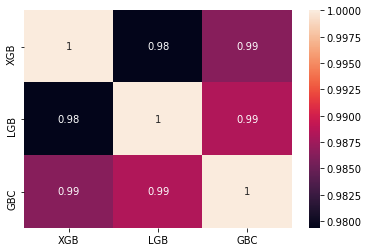

In [40]:
test_Survived_GBC = pd.Series(GBC_best.predict(test_rbst), name="GBC")
test_Survived_XGB = pd.Series(XGB_best.predict(test_rbst), name="XGB")
test_Survived_LGB = pd.Series(LGB_best.predict(test_rbst), name="LGB")

ensemble_results = pd.concat([test_Survived_XGB,test_Survived_LGB,
                              test_Survived_GBC],axis=1)
g= sns.heatmap(ensemble_results.corr(),annot=True)

In [41]:
ensemble = np.expm1(0.1*test_Survived_GBC + 0.8*test_Survived_XGB + 0.1*test_Survived_LGB)
prediction = pd.DataFrame({
    "player_id" :player_id,
    "name" : name,
    "HR": ensemble
})
prediction.head()

,player_id,name,HR
0,408234,Cabrera Miguel,12.274219
1,443558,Cruz Jr. Nelson,30.057480
2,444482,Peralta David,12.866851
3,453568,Blackmon Charlie,11.026575
4,457705,McCutchen Andrew,25.297494


In [42]:
prediction.to_csv('ensemble.csv')

- 보팅 (Voting)

In [43]:
from sklearn.ensemble import VotingRegressor

votingC = VotingRegressor(estimators=[('XGB', XGB_best), ('LGB', LGB_best), ('GBC',GBC_best)], n_jobs=4)
votingC = votingC.fit(X_rbst, y_data)  

In [44]:
test_HR = pd.Series(votingC.predict(test_rbst), name="HR")

In [45]:
predict_voting = pd.DataFrame({
    "player_id" :player_id,
    "name" : name,
    "HR": np.expm1(test_HR)
})
predict_voting.head()

,player_id,name,HR
0,408234,Cabrera Miguel,11.955077
1,443558,Cruz Jr. Nelson,30.841909
2,444482,Peralta David,13.152343
3,453568,Blackmon Charlie,10.992376
4,457705,McCutchen Andrew,24.712203


In [46]:
predict_voting.to_csv('voting.csv')

- 스태킹(stacking)

In [47]:
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.utils.testing import ignore_warnings

/home/minding/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [48]:
params = {'meta_regressor__C': [0.1, 1.0, 10.0, 100.0],
          'use_features_in_secondary' : [True, False]}

In [49]:
clf1 = XGB_best
clf2 = LGB_best
clf3 = GBC_best

lr = LogisticRegression()
st_re= StackingRegressor(regressors=[clf1, clf2, clf3], meta_regressor=RandomForestRegressor())
st_mod = st_re.fit(X_rbst, y_data)
st_pred = st_mod.predict(test_rbst)

In [50]:
predict_stacking = pd.DataFrame({
    "player_id" :player_id,
    "name" : name,
    "HR": np.expm1(st_pred)
})
predict_stacking.head()

,player_id,name,HR
0,408234,Cabrera Miguel,11.882983
1,443558,Cruz Jr. Nelson,28.928868
2,444482,Peralta David,12.007845
3,453568,Blackmon Charlie,11.051078
4,457705,McCutchen Andrew,26.803501


In [51]:
predict_stacking.to_csv('stacking.csv')

In [52]:
hr_21 = pd.read_csv('0727hr.csv')
hr_21.head()

,last_name,first_name,player_id,year,b_home_run,xba,xslg,xwoba,xobp,xiso,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel_batted_rate,Unnamed: 14
0,Cabrera,Miguel,408234,2021,7,0.221,0.375,0.290,0.281,0.154,91.1,10.6,31.6,7.2,NaN
1,Cruz Jr.,Nelson,443558,2021,21,0.280,0.534,0.388,0.367,0.254,93.6,10.9,32.1,14.5,NaN
2,Peralta,David,444482,2021,4,0.240,0.347,0.296,0.316,0.106,89.2,4.5,27.0,5.6,NaN
3,Blackmon,Charlie,453568,2021,6,0.288,0.427,0.356,0.376,0.138,87.6,8.7,29.9,5.5,NaN
4,McCutchen,Andrew,457705,2021,17,0.247,0.441,0.358,0.368,0.194,88.4,12.9,37.0,9.6,NaN


In [53]:
hr = hr_21.iloc[:,2:5]
hr

,player_id,year,b_home_run
0,408234,2021,7
1,443558,2021,21
2,444482,2021,4
3,453568,2021,6
4,457705,2021,17
...,...,...,...
135,668942,2021,10
136,669221,2021,12
137,669242,2021,6
138,669256,2021,9


In [54]:
ensemble = pd.merge(prediction, hr)
ensemble.to_csv('ensemble.csv')

In [55]:
voting = pd.merge(predict_voting, hr)
voting.to_csv('voting.csv')

In [56]:
stacking = pd.merge(predict_stacking, hr)
stacking.to_csv('stacking.csv')

In [57]:
import pandas as pd
ensemble = pd.read_csv('ensemble.csv')
voting = pd.read_csv('voting.csv')
stacking = pd.read_csv('stacking.csv')

In [58]:
ensemble.sort_values(by='HR', axis=0, ascending=False, inplace=True)
ensemble.head(10)

,Unnamed: 0,player_id,name,HR,year,b_home_run
106,106,660271,Ohtani Shohei,47.111312,2021,35
119,119,665487,Tatis Jr. Fernando,42.237224,2021,30
95,95,646240,Devers Rafael,41.689959,2021,26
107,107,660670,Acuna Jr. Ronald,41.234265,2021,24
79,79,621566,Olson Matt,39.307601,2021,27
120,120,665489,Guerrero Jr. Vladimir,39.279677,2021,32
42,42,571970,Muncy Max,37.477211,2021,22
31,31,543760,Semien Marcus,36.642096,2021,24
72,72,608336,Gallo Joey,36.538118,2021,24
118,118,665120,Walsh Jared,34.353419,2021,22


In [59]:
voting.sort_values(by='HR', axis=0, ascending=False, inplace=True)
voting.head(10)

,Unnamed: 0,player_id,name,HR,year,b_home_run
106,106,660271,Ohtani Shohei,44.844918,2021,35
119,119,665487,Tatis Jr. Fernando,41.736157,2021,30
95,95,646240,Devers Rafael,41.287290,2021,26
107,107,660670,Acuna Jr. Ronald,40.764371,2021,24
79,79,621566,Olson Matt,39.135405,2021,27
120,120,665489,Guerrero Jr. Vladimir,39.088296,2021,32
42,42,571970,Muncy Max,38.089192,2021,22
31,31,543760,Semien Marcus,36.635671,2021,24
72,72,608336,Gallo Joey,36.604278,2021,24
40,40,571745,Haniger Mitch,33.945183,2021,25


In [60]:
stacking.sort_values(by='HR', axis=0, ascending=False, inplace=True)
stacking.head(10)

,Unnamed: 0,player_id,name,HR,year,b_home_run
106,106,660271,Ohtani Shohei,47.568753,2021,35
119,119,665487,Tatis Jr. Fernando,42.369313,2021,30
95,95,646240,Devers Rafael,42.069544,2021,26
107,107,660670,Acuna Jr. Ronald,41.274876,2021,24
79,79,621566,Olson Matt,39.897945,2021,27
120,120,665489,Guerrero Jr. Vladimir,38.435841,2021,32
42,42,571970,Muncy Max,37.460382,2021,22
72,72,608336,Gallo Joey,36.565792,2021,24
118,118,665120,Walsh Jared,35.913330,2021,22
31,31,543760,Semien Marcus,35.711850,2021,24
